# Template to Exercise 2

Author: Tobias Stollenwerk, Nil Rodellas Gràcia, Institute for Quantum Computing Analytics (PGI-12), FZ Jülich

**Please use this template for exercise 2**

## Exercise 2.1

In [1]:
import qiskit
# numerics
import numpy as np
# functional programmin tools
import itertools
import functools
import operator
# plotting
import matplotlib.pyplot as plt
import seaborn
# data analysis
import pandas as pd
# qiskit 
from qiskit import QuantumCircuit, transpile
from qiskit_aer import QasmSimulator, AerSimulator
from qiskit.quantum_info import Pauli
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.quantum_info import Kraus, SuperOp, SparsePauliOp, Operator, DensityMatrix, Statevector
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, depolarizing_error
from qiskit.circuit import ParameterVector

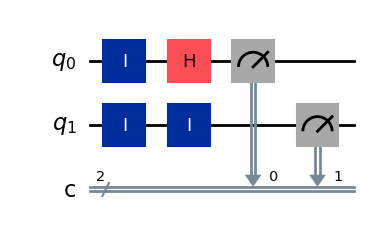

In [2]:
circuit = QuantumCircuit(2, 2)
circuit.id(0)
circuit.id(1)
circuit.h(0)
circuit.id(1)
circuit.measure(0, 0)
circuit.measure(1, 1);
# display the circuit
display(circuit.draw('mpl'))

In [3]:
p = 0.1

error_1 = depolarizing_error(p, 1)

In [4]:
p0given1 = 0.1
p1given0 = 0.05

error_readout = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

In [5]:
# ... build noise model here

## Exercise 2.2 - quantum optimization
### Hints

Consider the MaxCut case

$$
H_f = \sum_{u, v \in E} Z_u Z_v
$$

for the edge set $E = \{(1, 2), (2, 3), (2, 4), (3, 4)\}$

In [6]:
E = [(1, 2), (2, 3), (2, 4), (3, 4)]
V = [1, 2, 3, 4]

pauli_strings = []
for u, v in E:
    pauli_strings.append("".join(["I" if i not in (u, v) else "Z" for i in V ]))
H = SparsePauliOp(pauli_strings)


In [7]:
basis_states = {}
ket = {0: Statevector([1, 0]), 1: Statevector([0, 1])}
for i, bitstring in enumerate(itertools.product([0, 1], repeat=4)):
    state = ket[bitstring[0]]
    for k in range(len(bitstring) - 1):
        state = state.tensor(ket[bitstring[k + 1]])
    basis_states[bitstring] = state
print(basis_states.keys())

dict_keys([(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 1, 0), (0, 0, 1, 1), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 1, 0), (0, 1, 1, 1), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1), (1, 1, 0, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 1, 1)])


In [8]:
for bitstring, state in basis_states.items():
    f = state.expectation_value(H)
    print("<{}|H|{}> = {}".format(bitstring, bitstring, f))

<(0, 0, 0, 0)|H|(0, 0, 0, 0)> = (4+0j)
<(0, 0, 0, 1)|H|(0, 0, 0, 1)> = 0j
<(0, 0, 1, 0)|H|(0, 0, 1, 0)> = 0j
<(0, 0, 1, 1)|H|(0, 0, 1, 1)> = 0j
<(0, 1, 0, 0)|H|(0, 1, 0, 0)> = (-2+0j)
<(0, 1, 0, 1)|H|(0, 1, 0, 1)> = (-2+0j)
<(0, 1, 1, 0)|H|(0, 1, 1, 0)> = (-2+0j)
<(0, 1, 1, 1)|H|(0, 1, 1, 1)> = (2+0j)
<(1, 0, 0, 0)|H|(1, 0, 0, 0)> = (2+0j)
<(1, 0, 0, 1)|H|(1, 0, 0, 1)> = (-2+0j)
<(1, 0, 1, 0)|H|(1, 0, 1, 0)> = (-2+0j)
<(1, 0, 1, 1)|H|(1, 0, 1, 1)> = (-2+0j)
<(1, 1, 0, 0)|H|(1, 1, 0, 0)> = 0j
<(1, 1, 0, 1)|H|(1, 1, 0, 1)> = 0j
<(1, 1, 1, 0)|H|(1, 1, 1, 0)> = 0j
<(1, 1, 1, 1)|H|(1, 1, 1, 1)> = (4+0j)
